# Assignment 3

> Tristan PERROT

## Utils

### Imports


In [38]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import math
from tqdm.notebook import trange

DATASET_PATH = '../Dataset/'

In [39]:
for i in range(torch.cuda.device_count()):
    print(torch.cuda.get_device_properties(i).name)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [40]:
def load_batch(filename):
    """ Copied from the dataset website """
    import pickle
    with open(DATASET_PATH + filename, 'rb') as fo:
        data = pickle.load(fo, encoding='bytes')
    return data


def load_data(filename):
    """ Read the data from the file """
    data = load_batch(filename)
    X = data[b'data'].T / 255
    y = np.array(data[b'labels'])
    Y = np.zeros((10, X.shape[1]))
    for i in range(y.shape[0]):
        Y[y[i], i] = 1
    return X, Y, y


def load_all_data():
    """ Load all the data """
    X, Y, y = load_data('data_batch_1')
    for i in range(2, 6):
        X_i, Y_i, y_i = load_data(f'data_batch_{i}')
        X = np.concatenate((X, X_i), axis=1)
        Y = np.concatenate((Y, Y_i), axis=1)
        y = np.concatenate((y, y_i))
    X_test_, Y_test_, y_test_ = load_data('test_batch')
    return X, Y, y, X_test_, Y_test_, y_test_

In [41]:
def compute_relative_error(grad_analytical, grad_numerical, eps=1e-9):
    """ Compute the relative error between the analytical and numerical gradients """
    return torch.max(
        torch.abs(grad_analytical - grad_numerical) / torch.clamp(
            torch.abs(grad_analytical) + torch.abs(grad_numerical) + eps, min=eps))

## Exercises

### Model


In [111]:
def compute_eta(eta_min, eta_max, t, n_s):
    t = t % (2 * n_s)
    if t < n_s:
        return eta_min + t / n_s * (eta_max - eta_min)
    else:
        return eta_max - (t - n_s) / n_s * (eta_max - eta_min)


class Classifier:
    def __init__(self, x_train, x_val, x_test, y_train, y_val, y_test, y_1d_train, y_1d_val, y_1d_test, eta=0.001,
                 lambda_=0.0, device='cpu'):
        self.device = device
        
        self.x_train = torch.tensor(x_train, dtype=torch.float64).to(self.device)
        self.x_val = torch.tensor(x_val, dtype=torch.float64).to(self.device)
        self.x_test = torch.tensor(x_test, dtype=torch.float64).to(self.device)
        self.y_train = torch.tensor(y_train, dtype=torch.float64).to(self.device)
        self.y_val = torch.tensor(y_val, dtype=torch.float64).to(self.device)
        self.y_test = torch.tensor(y_test, dtype=torch.float64).to(self.device)
        self.y_1d_train = torch.tensor(y_1d_train, dtype=torch.float64).to(self.device)
        self.y_1d_val = torch.tensor(y_1d_val, dtype=torch.float64).to(self.device)
        self.y_1d_test = torch.tensor(y_1d_test, dtype=torch.float64).to(self.device)

        self.eta = eta
        self.lambda_ = lambda_

        self.W = []
        self.b = []

        self.costs_train = []
        self.costs_val = []
        self.losses_train = []
        self.losses_val = []
        self.accuracies_train = []
        self.accuracies_val = []

    def keep_n_data(self, n):
        self.x_train = self.x_train[:, :n]
        self.y_train = self.y_train[:, :n]
        self.y_1d_train = self.y_1d_train[:n]
        self.x_val = self.x_val[:, :n]
        self.y_val = self.y_val[:, :n]
        self.y_1d_val = self.y_1d_val[:n]
        self.x_test = self.x_test[:, :n]
        self.y_test = self.y_test[:, :n]
        self.y_1d_test = self.y_1d_test[:n]

    def keep_n_dim(self, n):
        self.x_train = self.x_train[:n]
        self.x_val = self.x_val[:n]
        self.x_test = self.x_test[:n]
        self.y_val = self.y_val[:n]
        self.y_train = self.y_train[:n]
        self.y_test = self.y_test[:n]
        self.y_1d_train = self.y_1d_train[:n]
        self.y_1d_val = self.y_1d_val[:n]
        self.y_1d_test = self.y_1d_test[:n]

    def preprocess(self):
        mean_X = torch.mean(self.x_train, dim=1, keepdim=True)
        std_X = torch.std(self.x_train, dim=1, keepdim=True)
        self.x_train = (self.x_train - mean_X) / std_X
        self.x_val = (self.x_val - mean_X) / std_X
        self.x_test = (self.x_test - mean_X) / std_X

    def initialize_weights(self, n_layers, hidden_sizes):
        features = self.x_train.shape[0]
        outputs = self.y_train.shape[0]

        for i in range(n_layers):
            if i == 0:
                self.W.append(torch.randn(hidden_sizes[i], features, dtype=torch.float64, requires_grad=True).to(self.device) / math.sqrt(features))
                self.b.append(torch.zeros(hidden_sizes[i], 1, dtype=torch.float64, requires_grad=True).to(self.device))
            elif i == n_layers - 1:
                self.W.append(torch.randn(outputs, hidden_sizes[i - 1], dtype=torch.float64, requires_grad=True).to(self.device) / math.sqrt(hidden_sizes[i - 1]))
                self.b.append(torch.zeros(outputs, 1, dtype=torch.float64, requires_grad=True).to(self.device))
            else:
                self.W.append(torch.randn(hidden_sizes[i], hidden_sizes[i - 1], dtype=torch.float64, requires_grad=True).to(self.device) / math.sqrt(hidden_sizes[i - 1]))
                self.b.append(torch.zeros(hidden_sizes[i], 1, dtype=torch.float64, requires_grad=True).to(self.device))

    def forward(self, x, W, b):
        self.x_list = [x]
        self.s_list = []
        for l in range(len(W)):
            s = W[l] @ self.x_list[l] + b[l]
            self.s_list.append(s)
            if l == len(W) - 1:
                self.p = torch.softmax(s, dim=0)
            else:
                h = torch.relu(s)
                self.x_list.append(h)

    def cost(self, x, y, W, b):
        m = x.shape[1]
        self.forward(x, W, b)
        loss = -torch.sum(y * torch.log(self.p)) / m
        reg = self.lambda_ * sum(torch.sum(w**2) for w in W)
        return loss + reg, loss

    def cost_grad(self, x, y):
        m = x.shape[1]
        self.forward(x, self.W, self.b)
        grad_W = [torch.zeros_like(w) for w in self.W]
        grad_b = [torch.zeros_like(bi) for bi in self.b]

        g = -(y - self.p)

        for l in range(len(self.W) - 1, -1, -1):
            grad_W[l] = g @ self.x_list[l].T / m + 2 * self.lambda_ * self.W[l]
            grad_b[l] = torch.sum(g, dim=1, keepdim=True) / m
            if l > 0:
                g = (self.W[l].T @ g) * (self.s_list[l - 1] > 0)

        return grad_W, grad_b

    def accuracy(self, x, y):
        self.forward(x, self.W, self.b)
        correct = torch.sum(torch.argmax(y, dim=0) ==
                            torch.argmax(self.p, dim=0))
        return correct.item() / x.shape[1]

    def compute_grads_num(self, X, Y, W, b, h):
        grad_W = [torch.zeros_like(w) for w in W]
        grad_b = [torch.zeros_like(bi) for bi in b]

        c, _ = self.cost(X, Y, W, b)

        for j in range(len(b)):
            for i in range(len(b[j])):
                b_try = [bi.clone() for bi in b]
                b_try[j][i] += h
                c2, _ = self.cost(X, Y, W, b_try)
                grad_b[j][i] = (c2 - c) / h
        for j in range(len(W)):
            for i in range(np.prod(W[j].shape)):
                W_try = [wi.clone() for wi in W]
                idx = np.unravel_index(i, W[j].shape)
                W_try[j][idx] += h
                c2, _ = self.cost(X, Y, W_try, b)
                grad_W[j][idx] = (c2 - c) / h

        return grad_W, grad_b

    def check_grad(self):
        grad_W, grad_b = self.cost_grad(self.x_train, self.y_train)

        grad_W_num, grad_b_num = self.compute_grads_num(
            self.x_train, self.y_train, self.W, self.b, 1e-5)

        print('Between analytical and numerical gradients:')
        print('Biggest difference for W for every layer:', [torch.max(
            torch.abs(grad_W[i] - grad_W_num[i])).item() for i in range(len(grad_W))])
        print('Biggest difference for b for every layer:', [torch.max(
            torch.abs(grad_b[i] - grad_b_num[i])).item() for i in range(len(grad_b))])
        print('Biggest relative error for W for every layer:', [compute_relative_error(
            grad_W[i], grad_W_num[i]).item() for i in range(len(grad_W))])
        print('Biggest relative error for b for every layer:', [compute_relative_error(
            grad_b[i], grad_b_num[i]).item() for i in range(len(grad_b))])
    

        cost, _ = self.cost(self.x_train, self.y_train,
                            self.W, self.b)
        for i in range(len(self.W)):
            self.W[i].retain_grad()
            self.b[i].retain_grad()
        cost.backward()
        grad_W_autograd = [w.grad for w in self.W]
        grad_b_autograd = [b.grad for b in self.b]
        
        print('\nBetween analytical and autograd gradients:')
        print('Biggest difference for W for every layer:', [torch.max(
            torch.abs(grad_W[i] - grad_W_autograd[i])).item() for i in range(len(grad_W))])
        print('Biggest difference for b for every layer:', [torch.max(
            torch.abs(grad_b[i] - grad_b_autograd[i])).item() for i in range(len(grad_b))])
        print('Biggest relative error for W for every layer:', [compute_relative_error(
            grad_W[i], grad_W_autograd[i]).item() for i in range(len(grad_W))])
        print('Biggest relative error for b for every layer:', [compute_relative_error(
            grad_b[i], grad_b_autograd[i]).item() for i in range(len(grad_b))])
        
        print('\nBetween numerical and autograd gradients:')
        print('Biggest difference for W for every layer:', [torch.max(
            torch.abs(grad_W_num[i] - grad_W_autograd[i])).item() for i in range(len(grad_W))])
        print('Biggest difference for b for every layer:', [torch.max(
            torch.abs(grad_b_num[i] - grad_b_autograd[i])).item() for i in range(len(grad_b))])
        print('Biggest relative error for W for every layer:', [compute_relative_error(
            grad_W_num[i], grad_W_autograd[i]).item() for i in range(len(grad_W))])
        print('Biggest relative error for b for every layer:', [compute_relative_error(
            grad_b_num[i], grad_b_autograd[i]).item() for i in range(len(grad_b))])
        
        for i in range(len(self.W)):
            self.W[i].grad.zero_()
            self.b[i].grad.zero_()

    def mini_batch_gd(self, batch_size, n_epochs):
        n = self.x_train.shape[1]
        n_batch = math.ceil(n / batch_size)
        p_bar = trange(n_epochs)
        for epoch in p_bar:
            shuffle_idx = torch.randperm(n)
            x_train = self.x_train[:, shuffle_idx]
            y_train = self.y_train[:, shuffle_idx]
            for i in range(n_batch):
                start = i * batch_size
                end = min((i + 1) * batch_size, n)
                x_batch = x_train[:, start:end]
                y_batch = y_train[:, start:end]
                dW1, db1, dW2, db2 = self.cost_grad(x_batch, y_batch)
                with torch.no_grad():
                    self.W[0] -= self.eta * dW1
                    self.b[0] -= self.eta * db1
                    self.W[1] -= self.eta * dW2
                    self.b[1] -= self.eta * db2
            cost_train, loss_train = self.cost(
                self.x_train, self.y_train, self.W[0], self.b[0], self.W[1], self.b[1])
            cost_val, loss_val = self.cost(self.x_val, self.y_val,
                                           self.W[0], self.b[0], self.W[1], self.b[1])
            self.costs_train.append(cost_train.item())
            self.costs_val.append(cost_val.item())
            self.losses_train.append(loss_train.item())
            self.losses_val.append(loss_val.item())
            accuracy_train = self.accuracy(self.x_train, self.y_train)
            accuracy_val = self.accuracy(self.x_val, self.y_val)
            self.accuracies_train.append(accuracy_train)
            self.accuracies_val.append(accuracy_val)
            p_bar.set_description(f'Cost Train: {cost_train.item():.4f}, Cost Val: {cost_val.item():.4f}, Epoch: {epoch + 1}/{n_epochs}')

    def mini_batch_gd_cyclic(self, batch_size, n_s, n_cycles, pbar=True):
        n = self.x_train.shape[1]
        n_batch = math.ceil(n / batch_size)
        n_epoch = math.ceil(2 * n_s / n_batch)
        t = 0
        p_bar = trange(n_cycles) if pbar else range(n_cycles)
        for cycle in p_bar:
            p_bar.set_description(
                f'Cycle: {cycle + 1}/{n_cycles}') if pbar else None
            p_bar2 = trange(n_epoch, leave=False) if pbar else range(n_epoch)
            for epoch in p_bar2:
                shuffle_idx = torch.randperm(n)
                x_train = self.x_train[:, shuffle_idx]
                y_train = self.y_train[:, shuffle_idx]
                for i in range(n_batch):
                    start = i * batch_size
                    end = min((i + 1) * batch_size, n)
                    x_batch = x_train[:, start:end]
                    y_batch = y_train[:, start:end]
                    dW1, db1, dW2, db2 = self.cost_grad(x_batch, y_batch)
                    eta = compute_eta(1e-5, 1e-1, t, n_s)
                    with torch.no_grad():
                        self.W[0] -= eta * dW1
                        self.b[0] -= eta * db1
                        self.W[1] -= eta * dW2
                        self.b[1] -= eta * db2
                    t += 1
                cost_train, loss_train = self.cost(
                    self.x_train, self.y_train, self.W[0], self.b[0], self.W[1], self.b[1])
                cost_val, loss_val = self.cost(
                    self.x_val, self.y_val, self.W[0], self.b[0], self.W[1], self.b[1])
                self.costs_train.append(cost_train.item())
                self.costs_val.append(cost_val.item())
                self.losses_train.append(loss_train.item())
                self.losses_val.append(loss_val.item())
                accuracy_train = self.accuracy(self.x_train, self.y_train)
                accuracy_val = self.accuracy(self.x_val, self.y_val)
                self.accuracies_train.append(accuracy_train)
                self.accuracies_val.append(accuracy_val)
                p_bar2.set_description(f'Cost Train: {cost_train.item():.4f}, Cost Val: {cost_val.item():.4f}, Epoch: {epoch + 1}/{n_epoch}') if pbar else None

    def plot_costs_acc(self):
        fig, ax = plt.subplots(1, 3, figsize=(15, 5))
        ax[0].plot(self.costs_train, label='Train')
        ax[0].plot(self.costs_val, label='Validation')
        ax[0].set_title('Cost vs Epochs')
        ax[0].set_xlabel('Epochs')
        ax[0].set_ylabel('Cost')
        ax[0].legend()
        ax[0].grid()
        ax[1].plot(self.losses_train, label='Train')
        ax[1].plot(self.losses_val, label='Validation')
        ax[1].set_title('Loss vs Epochs')
        ax[1].set_xlabel('Epochs')
        ax[1].set_ylabel('Loss')
        ax[1].legend()
        ax[1].grid()
        ax[2].plot(self.accuracies_train, label='Train')
        ax[2].plot(self.accuracies_val, label='Validation')
        ax[2].set_title('Accuracy vs Epochs')
        ax[2].set_xlabel('Epochs')
        ax[2].set_ylabel('Accuracy')
        ax[2].legend()
        ax[2].grid()
        fig.tight_layout()
        print('Train Accuracy:', self.accuracies_train[-1])
        print('Validation Accuracy:', self.accuracies_val[-1])
        print('Test Accuracy:', self.accuracy(self.x_test, self.y_test))
        plt.show()

## Exercise 1 & 2


In [113]:
X_train, Y_train, y_train = load_data('data_batch_1')
X_val, Y_val, y_val = load_data('data_batch_2')
X_test, Y_test, y_test = load_data('test_batch')

n = 20
dim = 50

classifier = Classifier(X_train, X_val, X_test, Y_train,
                        Y_val, Y_test, y_train, y_val, y_test, eta=0.001, lambda_=0.0)
classifier.keep_n_data(n)
classifier.keep_n_dim(dim)
classifier.preprocess()
classifier.initialize_weights(3, [50, 20])
classifier.check_grad()

Between analytical and numerical gradients:
Biggest difference for W for every layer: [9.737009378993355e-08, 5.682652610798644e-07, 6.026416887044972e-07]
Biggest difference for b for every layer: [6.065972020779381e-08, 3.078103041967428e-07, 6.26147088074458e-07]
Biggest relative error for W for every layer: [0.0005144836368598933, 0.0004245945919212278, 0.0007491846611836898]
Biggest relative error for b for every layer: [0.00010286843745221899, 6.083017278492138e-05, 1.167525044443254e-05]

Between analytical and autograd gradients:
Biggest difference for W for every layer: [2.42861286636753e-17, 4.163336342344337e-17, 2.7755575615628914e-17]
Biggest difference for b for every layer: [1.0408340855860843e-17, 2.0816681711721685e-17, 3.469446951953614e-17]
Biggest relative error for W for every layer: [2.746496529827413e-13, 8.95530693364797e-14, 1.2856304149614917e-14]
Biggest relative error for b for every layer: [3.252336844801732e-14, 9.394590482017042e-15, 5.295253136305291e-16

In [114]:
n = 100
hidden_size = 50

classifier = Classifier(X_train, X_val, X_test, Y_train,
                        Y_val, Y_test, y_train, y_val, y_test, eta=0.005, lambda_=0.0)
classifier.keep_n_data(n)
classifier.preprocess()
classifier.initialize_weights(3, [50, 20])
classifier.mini_batch_gd(batch_size=50, n_epochs=200)

  0%|          | 0/200 [00:00<?, ?it/s]

ValueError: not enough values to unpack (expected 4, got 2)

Train Accuracy: 1.0
Validation Accuracy: 0.21
Test Accuracy: 0.14


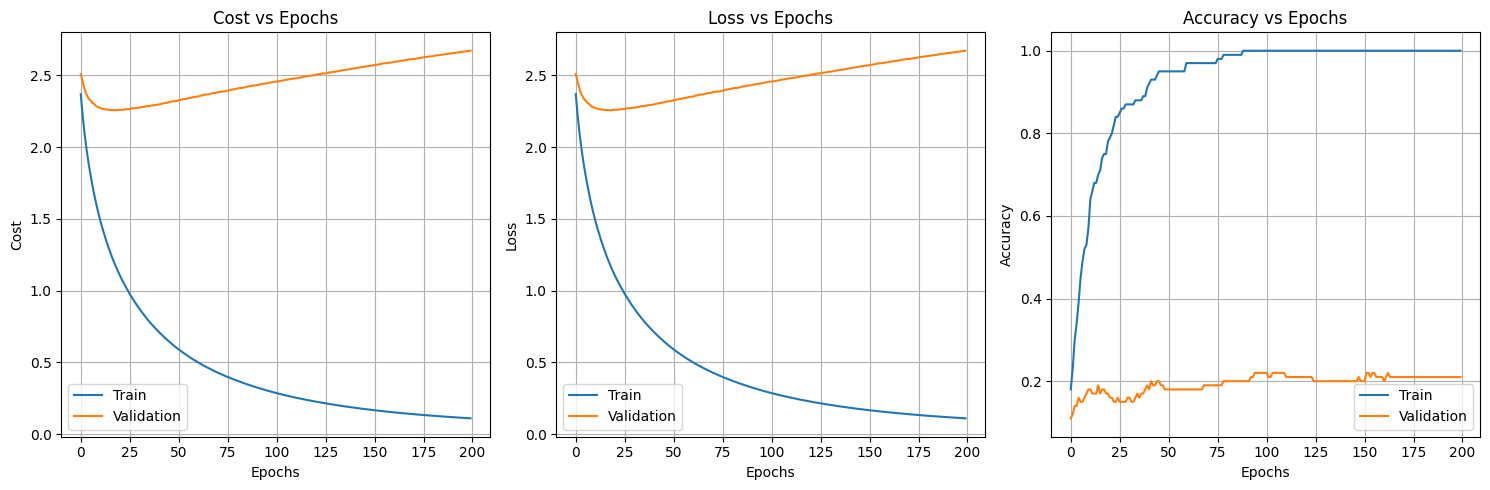

In [7]:
classifier.plot_costs_acc()

## Exercise 3


In [8]:
classifier = Classifier(X_train, X_val, X_test, Y_train,
                        Y_val, Y_test, y_train, y_val, y_test, eta=0.005, lambda_=.01)
classifier.preprocess()
classifier.initialize_weights(hidden_size=50)
classifier.mini_batch_gd_cyclic(batch_size=100, n_s=500, n_cycles=1)

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

Train Accuracy: 0.604
Validation Accuracy: 0.4515
Test Accuracy: 0.4595


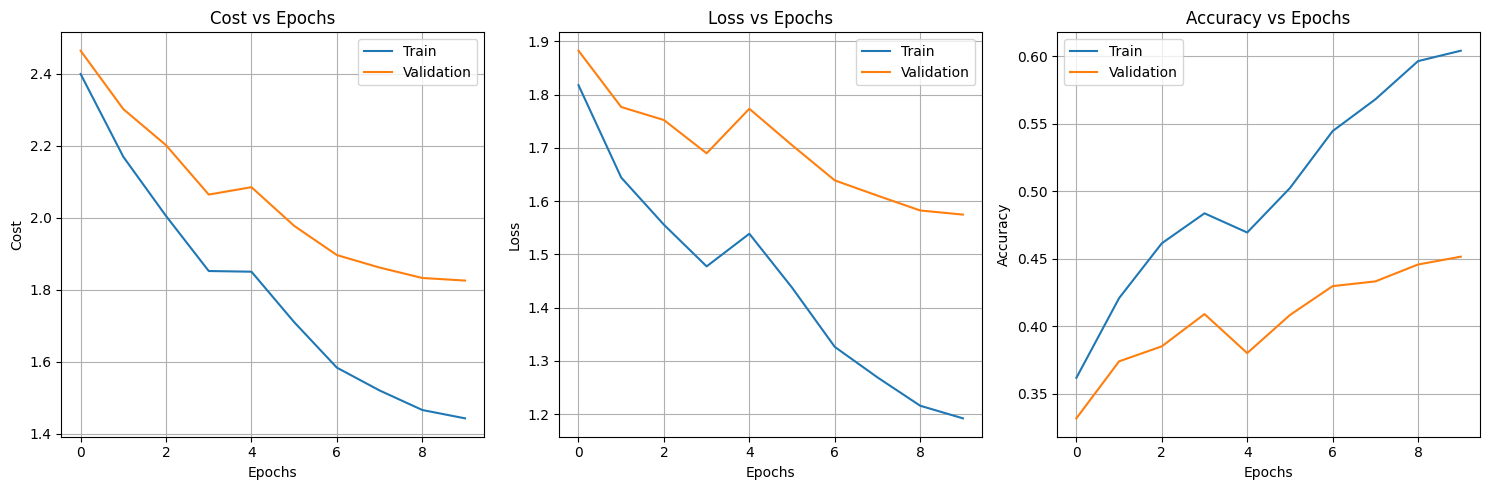

In [9]:
classifier.plot_costs_acc()

## Exercise 4


In [10]:
classifier = Classifier(X_train, X_val, X_test, Y_train,
                        Y_val, Y_test, y_train, y_val, y_test, eta=0.005, lambda_=.01)
classifier.preprocess()
classifier.initialize_weights(hidden_size=50)
classifier.mini_batch_gd_cyclic(batch_size=100, n_s=800, n_cycles=3)

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

Train Accuracy: 0.7178
Validation Accuracy: 0.4661
Test Accuracy: 0.4809


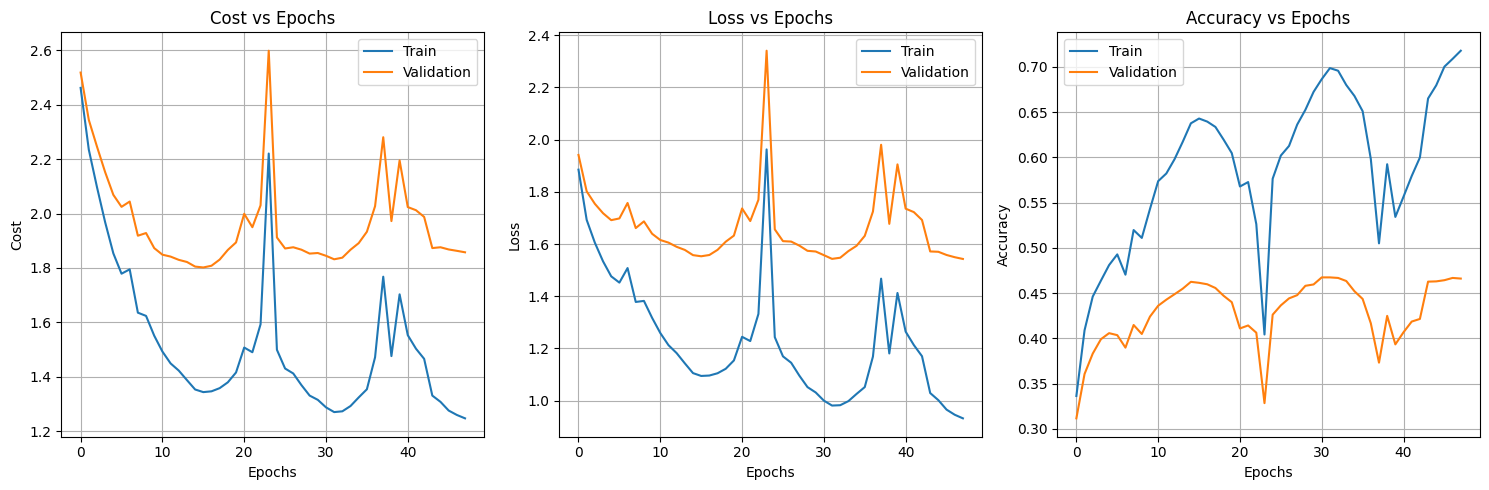

In [11]:
classifier.plot_costs_acc()

### Coarse-to-fine random search


In [12]:
X, Y, y, X_test, Y_test, y_test = load_all_data()

X_train = X[:, :45000]
Y_train = Y[:, :45000]
y_train = y[:45000]
X_val = X[:, 45000:]
Y_val = Y[:, 45000:]
y_val = y[45000:]

print('Train:', X_train.shape, Y_train.shape, y_train.shape)
print('Validation:', X_val.shape, Y_val.shape, y_val.shape)

Train: (3072, 45000) (10, 45000) (45000,)
Validation: (3072, 5000) (10, 5000) (5000,)


In [13]:
def random_search(n_iter, n_cycles, batch_size, l_min, l_max):
    n_batch = math.ceil(X_train.shape[1] / batch_size)
    n_s = 2 * math.floor(X_train.shape[1] / n_batch)
    accuracies = []
    lambdas = []
    pbar = trange(n_iter)
    for i in pbar:
        l = l_min + torch.rand(1) * (l_max - l_min)
        lambda_ = 10 ** l
        classifier = Classifier(X_train, X_val, X_test, Y_train,
                                Y_val, Y_test, y_train, y_val, y_test, eta=None, lambda_=lambda_)
        classifier.preprocess()
        classifier.initialize_weights(hidden_size=50)
        classifier.mini_batch_gd_cyclic(
            batch_size=batch_size, n_s=n_s, n_cycles=n_cycles, pbar=False)
        accuracies.append(classifier.accuracy(
            classifier.x_val, classifier.y_val))
        lambdas.append(lambda_)
        pbar.set_description(f'Iter: {i + 1}/{n_iter}')
    return accuracies, lambdas

#### Coarse search

In [28]:
accuracies, lambdas = random_search(20, 2, 100, -5, -1)
# Save the accuracies and lambdas in a file
torch.save(accuracies, 'tensors/accuracies_coarse.pth')
torch.save(lambdas, 'tensors/lambdas_coarse.pth')
# Best lambda
best_lambda = lambdas[np.argmax(accuracies)]
print('Best lambda:', best_lambda, 'with accuracy:', max(accuracies))

  0%|          | 0/20 [00:00<?, ?it/s]

Best lambda: tensor([8.8871e-05]) with accuracy: 0.473


In [29]:
# Load the accuracies and lambdas
accuracies = torch.load('tensors/accuracies_coarse.pth')
lambdas = torch.load('tensors/lambdas_coarse.pth')

# Ranks the lambdas based on the accuracies descending
idx = np.argsort(accuracies)[::-1]
lambdas = [lambdas[i] for i in idx]
accuracies = [accuracies[i] for i in idx]

# Print the top 5 lambdas
print('Top 5 lambdas:')
for i in range(5):
    print(f'Lambda: {lambdas[i].item():.4}, Accuracy: {accuracies[i]}')

Top 5 lambdas:
Lambda: 8.887e-05, Accuracy: 0.473
Lambda: 0.0007362, Accuracy: 0.468
Lambda: 0.0008308, Accuracy: 0.464
Lambda: 1.181e-05, Accuracy: 0.464
Lambda: 0.002427, Accuracy: 0.463


#### Fine search

In [30]:
# Get the l_min and l_max from the 5 best lambdas
lambda_min = min(lambdas[:5])
lambda_max = max(lambdas[:5])
print('Lambda min:', lambda_min)
print('Lambda max:', lambda_max)
l_min = math.log10(lambda_min)
l_max = math.log10(lambda_max)

accuracies, lambdas = random_search(20, 2, 100, l_min, l_max)
# Save the accuracies and lambdas in a file
torch.save(accuracies, 'tensors/accuracies_fine.pth')
torch.save(lambdas, 'tensors/lambdas_fine.pth')
# Best lambda
best_lambda = lambdas[np.argmax(accuracies)]
print('Best lambda:', best_lambda, 'with accuracy:', max(accuracies))


Lambda min: tensor([1.1809e-05])
Lambda max: tensor([0.0024])


  0%|          | 0/20 [00:00<?, ?it/s]

Best lambda: tensor([0.0001]) with accuracy: 0.471


In [31]:
# Load the accuracies and lambdas
accuracies = torch.load('tensors/accuracies_fine.pth')
lambdas = torch.load('tensors/lambdas_fine.pth')

# Ranks the lambdas based on the accuracies descending
idx = np.argsort(accuracies)[::-1]
lambdas = [lambdas[i] for i in idx]
accuracies = [accuracies[i] for i in idx]

# Print the top 5 lambdas
print('Top 5 lambdas:')
for i in range(5):
    print(f'Lambda: {lambdas[i].item():.4}, Accuracy: {accuracies[i]}')


Top 5 lambdas:
Lambda: 0.0001349, Accuracy: 0.471
Lambda: 4.93e-05, Accuracy: 0.457
Lambda: 0.0001497, Accuracy: 0.457
Lambda: 0.0008902, Accuracy: 0.456
Lambda: 0.0007884, Accuracy: 0.453


In [32]:
# Get the l_min and l_max from the 5 best lambdas
lambda_min = min(lambdas[:5])
lambda_max = max(lambdas[:5])
print('Lambda min:', lambda_min)
print('Lambda max:', lambda_max)
l_min = math.log10(lambda_min)
l_max = math.log10(lambda_max)

accuracies, lambdas = random_search(20, 2, 100, l_min, l_max)
# Save the accuracies and lambdas in a file
torch.save(accuracies, 'tensors/accuracies_fine_fine.pth')
torch.save(lambdas, 'tensors/lambdas_fine_fine.pth')
# Best lambda
best_lambda = lambdas[np.argmax(accuracies)]
print('Best lambda:', best_lambda, 'with accuracy:', max(accuracies))


Lambda min: tensor([4.9296e-05])
Lambda max: tensor([0.0009])


  0%|          | 0/20 [00:00<?, ?it/s]

Best lambda: tensor([0.0003]) with accuracy: 0.485


#### Final Performance

In [11]:
accuracies = torch.load('tensors/accuracies_fine_fine.pth')
lambdas = torch.load('tensors/lambdas_fine_fine.pth')

# Ranks the lambdas based on the accuracies descending
idx = np.argsort(accuracies)[::-1]
lambdas = [lambdas[i] for i in idx]
accuracies = [accuracies[i] for i in idx]

best_lambda = lambdas[0]

X, Y, y, X_test, Y_test, y_test = load_all_data()

X_train = X[:, :49000]
Y_train = Y[:, :49000]
y_train = y[:49000]
X_val = X[:, 49000:]
Y_val = Y[:, 49000:]
y_val = y[49000:]

classifier = Classifier(X_train, X_val, X_test, Y_train,
                        Y_val, Y_test, y_train, y_val, y_test, eta=None, lambda_=best_lambda)
classifier.preprocess()
classifier.initialize_weights(hidden_size=50)
n_batch = math.ceil(X_train.shape[1] / 100)
n_s = 2 * math.floor(X_train.shape[1] / n_batch) * 3
print(n_s)
classifier.mini_batch_gd_cyclic(batch_size=200, n_s=n_s, n_cycles=5)

600


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

Train Accuracy: 0.6312040816326531
Validation Accuracy: 0.522
Test Accuracy: 0.5149


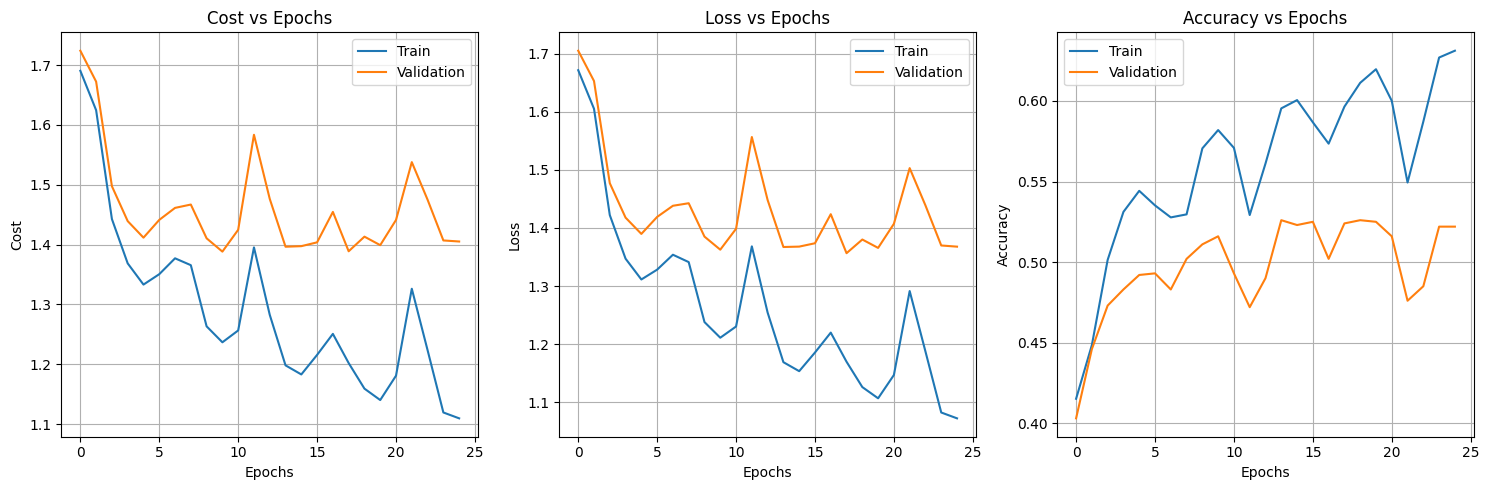

In [12]:
classifier.plot_costs_acc()